## 2D Square Ising, OBC, Metropolis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [4]:
import copy
import time

In [5]:
import numba as nb

In [6]:
import pickle

In [7]:
### fix the random seed
seed = 0
np.random.seed(seed)

-----------

In [8]:
global grids, dims, beta, j, h, delta

In [9]:
def parameters_init(dims_init, beta_init, j_init, h_init):
    global grids, dims, beta, j, h
    dims = (nb.int8(dims_init[0]), nb.int8(dims_init[1]))
    beta, j, h = nb.float64(beta_init), nb.int8(j_init), nb.int8(h_init)
    grids = np.reshape(np.random.choice([nb.int8(-1), nb.int8(1)], 
                                         size=dims_init[0]*dims_init[1]), dims_init)

In [10]:
### initialize the parameters
#dims_init = (4, 4)
#dims_init = (8, 8)
dims_init = (16, 16)
beta_init, j_init, h_init = np.log(1 + np.sqrt(2)) / 2, 1, 0

In [11]:
parameters_init(dims_init, beta_init, j_init, h_init)

--------------

In [12]:
types_neibor_get = nb.types.Tuple((nb.types.UniTuple(nb.types.UniTuple(nb.int8, 2), 4), nb.int8))(nb.types.UniTuple(nb.int8, 2))
@nb.cfunc(types_neibor_get)
def neibor_get(id_grid):
    height, width = dims
    height_index, width_index = id_grid
    l_neibor = (height_index, width_index-1)
    d_neibor = (height_index+1, width_index)                    
    r_neibor = (height_index, width_index+1)
    u_neibor = (height_index-1, width_index)
    if height_index == 0:
        if width_index == 0:
            neibors_tuple = ((d_neibor, r_neibor, (0, 0), (0, 0)), 2)
        elif width_index == dims[1] - 1:
            neibors_tuple = ((l_neibor, d_neibor, (0, 0), (0, 0)), 2)
        else:
            neibors_tuple = ((l_neibor, d_neibor, r_neibor, (0, 0)), 3)
    elif height_index == dims[0] - 1:
        if width_index == 0:
            neibors_tuple = ((r_neibor, u_neibor, (0, 0), (0, 0)), 2)
        elif width_index == dims[1] - 1:
            neibors_tuple = ((l_neibor, u_neibor, (0, 0), (0, 0)), 2)
        else:
            neibors_tuple = ((l_neibor, r_neibor, u_neibor, (0, 0)), 3)
    else:
        if width_index == 0:
            neibors_tuple = ((d_neibor, r_neibor, u_neibor, (0, 0)), 3)
        elif width_index == dims[1] - 1:
            neibors_tuple = ((l_neibor, d_neibor, u_neibor, (0, 0)), 3)
        else:
            neibors_tuple = ((l_neibor, d_neibor, r_neibor, u_neibor), 4)
    return neibors_tuple

In [13]:
types_energy_compute_one_grid = nb.int32(nb.int8[:, :], nb.types.UniTuple(nb.int8, 2), nb.int8)
@nb.njit(types_energy_compute_one_grid)
def energy_compute_one_grid(grids, id_grid, id_spin):
    energy_one_site = 0
    id_neibors, num_neibors = neibor_get(id_grid)
    id_row, id_col = id_grid     
    for i in range(num_neibors):
        neibor = id_neibors[i]
        energy_one_site += -j * grids[neibor[0]][neibor[1]] * id_spin
    energy_one_site += -h * id_spin
    return energy_one_site

In [14]:
@nb.njit(nb.float32(nb.int8[:, :]))
def energy_compute_grids(grids):
    energy_total = 0
    for ii in range(dims[0]):
        for jj in range(dims[1]):
            id_neibors, num_neibors = neibor_get((nb.int8(ii), nb.int8(jj)))
            for k in range(num_neibors):
                ij = id_neibors[k]
                energy_ij = -1/2 * j * grids[ij[0]][ij[1]] * grids[ii][jj]
                energy_total += energy_ij
            ### compute the energy of external field
            energy_total += -h * grids[ii][jj]
    energy_per_spin = energy_total / (dims[0] * dims[1])
    return energy_per_spin

In [15]:
@nb.njit(nb.float32(nb.int8[:, :]))
def magnet_grids(grid):
    m_abs_per_spin = np.mean(grid)
    return m_abs_per_spin

In [16]:
@nb.njit(nb.int8[:, :](nb.int8[:, :]))
def one_site_mcmc(grids):
    id_random = np.random.randint(dims[0]*dims[1])
    id_height, id_width = nb.int8(id_random // dims[1]), nb.int8(id_random % dims[1])
    spin_old = grids[id_height][id_width]
    spin_new = nb.int8(-1 * spin_old)
    energy_old = energy_compute_one_grid(grids, (id_height, id_width), spin_old)
    energy_new = energy_compute_one_grid(grids, (id_height, id_width), spin_new)
    energy_delta = energy_new - energy_old
    if energy_delta <= 0:
        grids[id_height][id_width] = spin_new
    else:
        prob_accept = np.exp(-beta * energy_delta)
        if np.random.random() < prob_accept:
            grids[id_height][id_width] = spin_new
    return grids

In [17]:
@nb.njit(nb.int8[:, :](nb.int8[:, :]))
def one_step_mcmc(grids):
    for _ in range(dims[0]*dims[1]):
        grids = one_site_mcmc(grids)
    return grids

In [18]:
type_mcmc_func = nb.types.Tuple((nb.int8[:, :], nb.float32[:], nb.float32[:]))(nb.int8[:, :], nb.int32)
@nb.njit(type_mcmc_func)
def mcmc(grids, steps):
    energy_history = np.zeros(steps, dtype=np.float32)
    m_history = np.zeros(steps, dtype=np.float32)
    for i in range(steps):
        grids = one_step_mcmc(grids)
        #energy_per_spin = energy_compute_grids(grids)
        m_per_spin = magnet_grids(grids)
        #energy_history[i] = energy_per_spin
        m_history[i] = m_per_spin
    return grids, energy_history, m_history

In [19]:
def spin_viz(figsize=(10, 10), save=False, folder_name=None):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(grids*np.pi/2)
    v = np.sin(grids*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title('T={:.3f}, spins={}'.format(1/beta, dims), fontsize=20)
    if save and step is not None:
        plt.savefig(f'./{folder_name}/config_plot_step_{step}.pdf', dpi=100)
        plt.close(fig)

In [20]:
def spin_viz_dynamic(self, spins_list, file_name, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    x, y = np.meshgrid(np.arange(0, dims[0]), np.arange(0, dims[1]))
    u = np.cos(spins_list[0]*np.pi/2)
    v = np.sin(spins_list[0]*np.pi/2)
    q = plt.quiver(x, y, u, v)
    plt.axis('off')
    plt.title(f'T={1/beta:.3f}, dims={dims}', fontsize=20)            
    def update_quiver(num, q):
        u = np.cos(spins_list[num+1]*np.pi/2)
        v = np.sin(spins_list[num+1]*np.pi/2)
        q.set_UVC(u, v)
        return q
    frames = len(spins_list) - 1
    anim = animation.FuncAnimation(fig, update_quiver, frames=frames, 
                                   fargs=(q, ), interval=50, repeat=False)
    writergif = animation.PillowWriter(fps=100) 
    anim.save(f'./{file_name}.gif', writer=writergif)

--------
### Size = 4

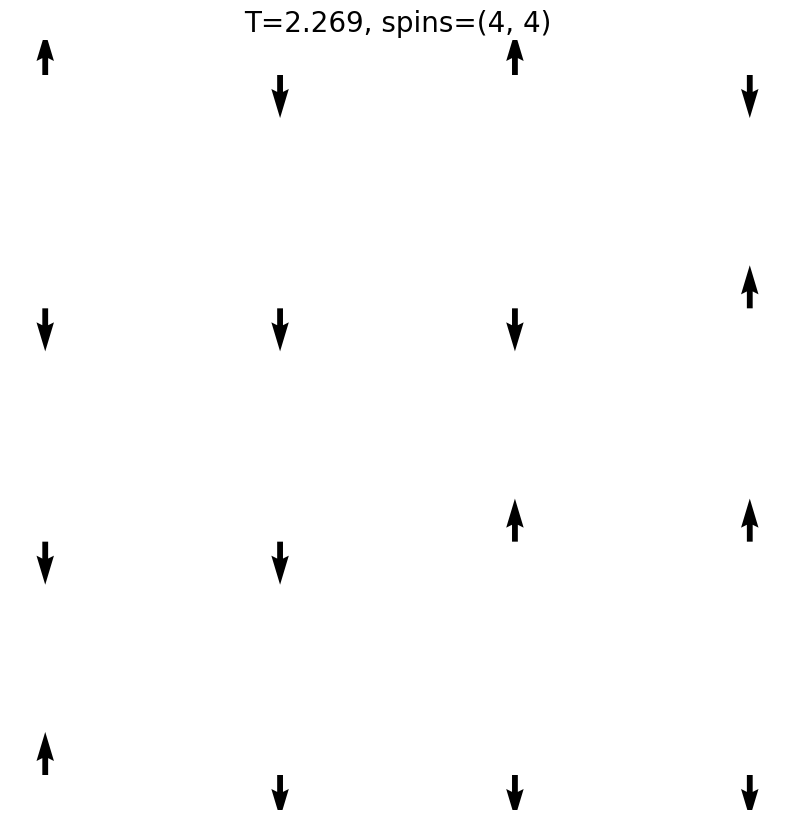

In [24]:
spin_viz()

In [72]:
### Burning-in stage
time_start = time.time()
grids, energy_history, m_history = mcmc(grids, 1000000)
time_end = time.time()
print(f"Time used for 1E6 steps is: {time_end-time_start}.")

Time used for 1E6 steps is: 2.559892177581787.


In [73]:
m_mean = np.mean(np.abs(m_history))

In [74]:
print(f"mean of m of size {dims[0]} is: {m_mean:.3f}.")

mean of m of size 4 is: 0.534.


----
### Size = 8

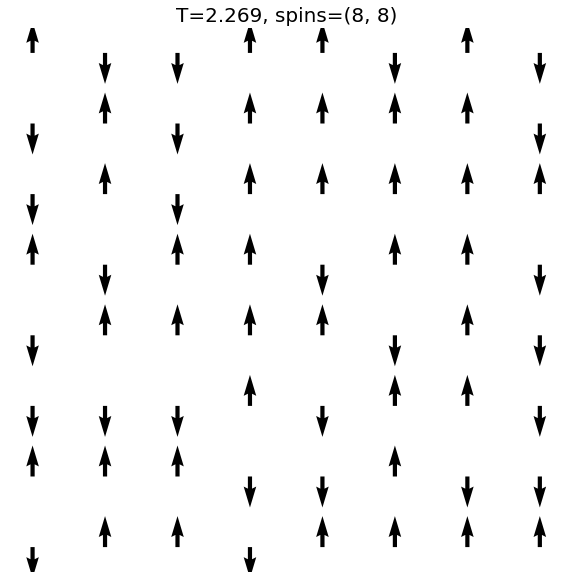

In [41]:
spin_viz()

In [118]:
### Burning-in stage
time_start = time.time()
grids, energy_history, m_history = mcmc(grids, 100000)
time_end = time.time()
print(f"Time used for 1E6 steps is: {time_end-time_start}.")

Time used for 1E6 steps is: 0.8682277202606201.


In [119]:
m_abs_mean = np.mean(np.abs(m_history))

In [120]:
print(f"abs mean of m is: {m_abs_mean:.3f}.")

abs mean of m is: 0.454.


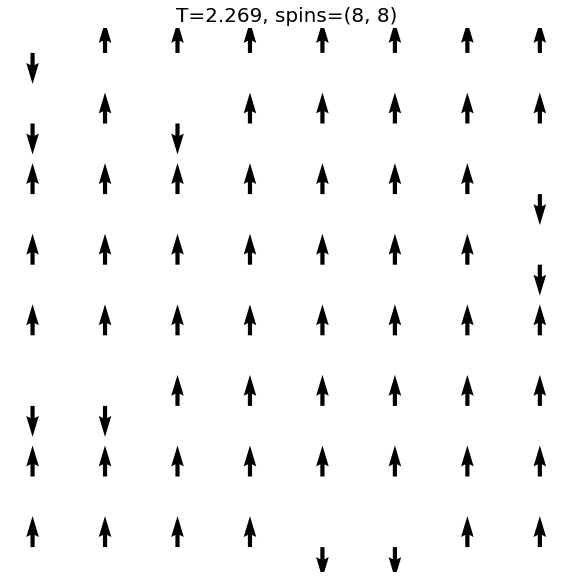

In [105]:
spin_viz()

--------
### Size = 16

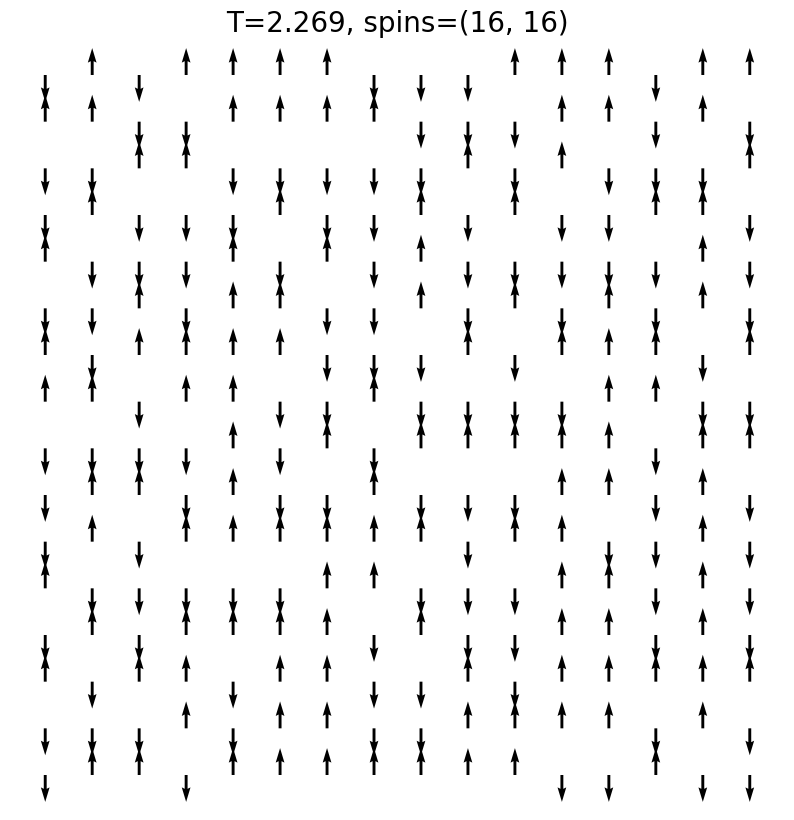

In [21]:
spin_viz()

In [22]:
### Burning-in stage
time_start = time.time()
grids, energy_history, m_history = mcmc(grids, 1000000)
time_end = time.time()
print(f"Time used for 1E6 steps is: {time_end-time_start}.")

Time used for 1E6 steps is: 132.46686482429504.


In [23]:
m_abs_mean = np.mean(np.abs(m_history))

In [24]:
print(f"abs mean of m of size {dims[0]} is: {m_abs_mean:.3f}.")

abs mean of m of size 16 is: 0.392.


-----
### Size effect

In [25]:
size_array = np.array([4, 8, 16])

In [26]:
m2_array = np.array([0.534, 
                     0.454,
                     0.392])

Text(0.5, 1.0, 'Size effect on 2D Ising Square Lattice, OBC')

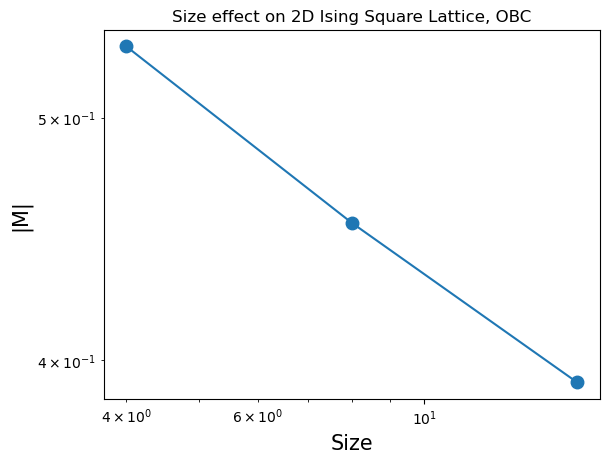

In [32]:
#plt.plot(size_array, coef_autocorr*size_array + bias, linewidth=3)
plt.plot(size_array, m2_array, '-o', markersize=9)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Size", fontsize=15)
plt.ylabel("|M|", fontsize=15)
plt.title("Size effect on 2D Ising Square Lattice, OBC")